In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

# set default plot size
plt.rcParams["figure.figsize"] = (15,8)

In [122]:
country=pd.read_csv('Country-data.csv')
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


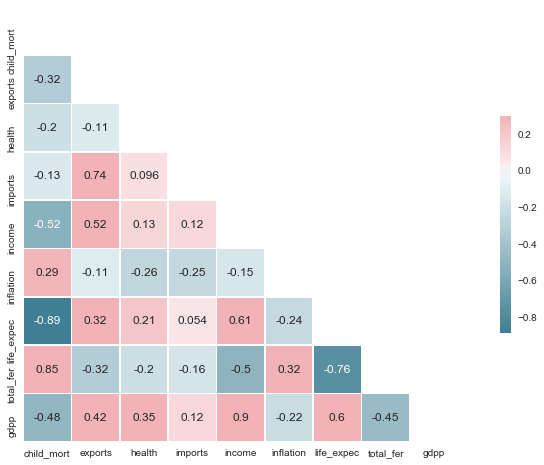

In [123]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(country.corr(), dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(country.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

from above correleation heatmap, we can get the following insights:

- exports is highly correlated with imports.
- health, exports, income,imports are highly correlated with gdpp.
- child_mort is having high negative correlation with life_expec.
- total_fer is highly positively correlated with child_mort and negatively correlated with life_expec

In [124]:
# scale the data
min_max_scaler = MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(country.drop('country',axis=1))
country_scale_df = pd.DataFrame(data = data_scaled,columns=country.columns[1:])
country_scale_df['country'] = country['country']
country_scale_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Afghanistan
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Albania
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Algeria
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Angola
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Antigua and Barbuda


## EDA:

child_mort


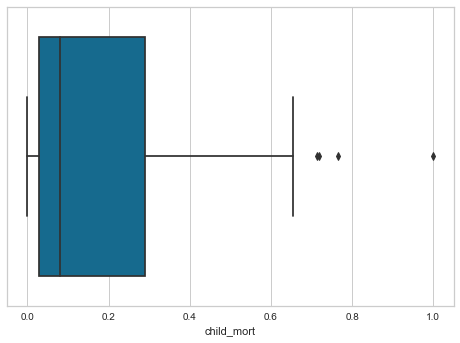

exports


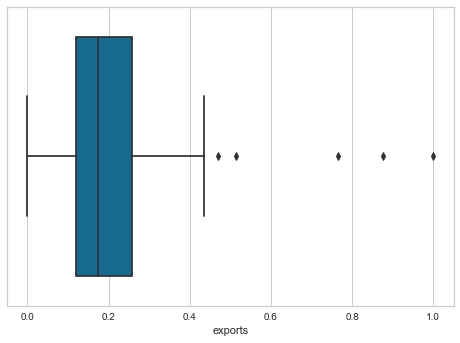

health


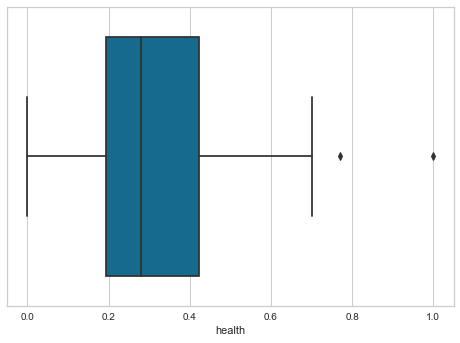

imports


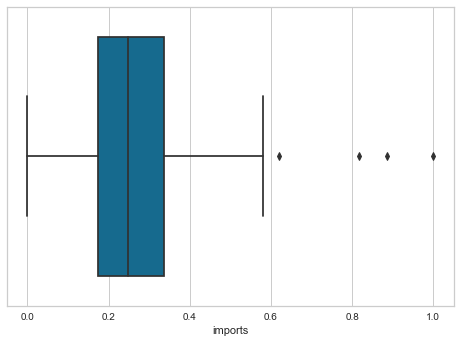

income


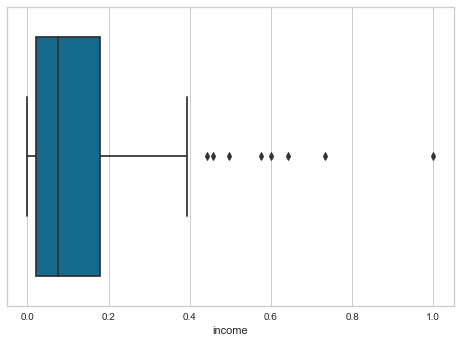

inflation


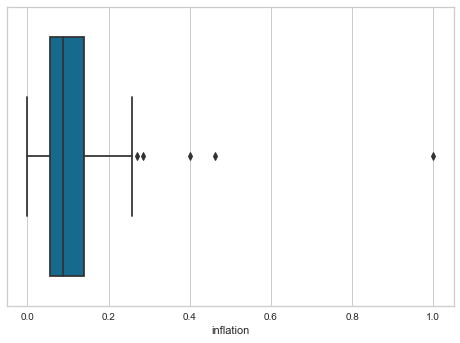

life_expec


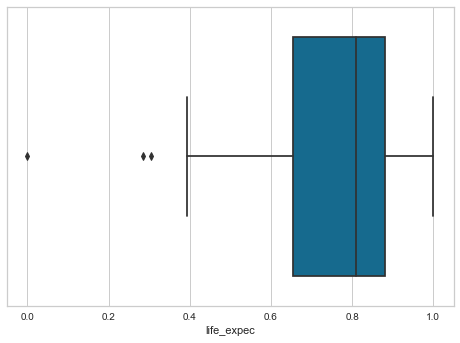

total_fer


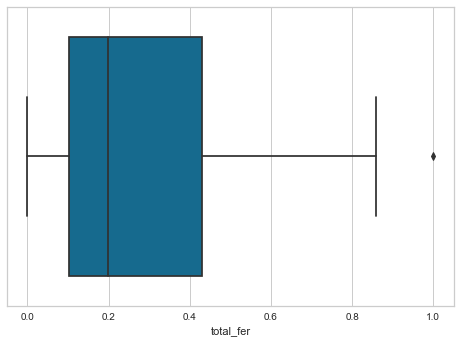

gdpp


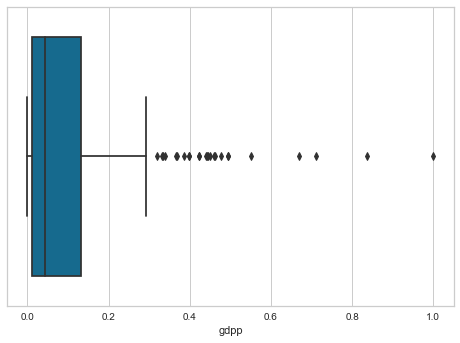

In [125]:
for i in country_scale_df[country_scale_df.columns[:-1]]:
    print(i)
    sns.boxplot(country_scale_df[i])
    plt.show()

From the above table, I conclude the following points:

- There is atleast one outlier in all the features
- In case of gdpp and health, there are too many outliers.
- Since we have limited number of countries(167), removing these outliers would shrink the shape of data and the under-developed countries which are in actual dire need may not contribute to the dataset.
- There could be a possibility in child_mort's subplot where those outliered-countries could be the needy ones because of the high child-mortality rate.
- **Removing outliers is not a good option as per the above conditions. Hence, I choose to KEEP outliers**.

### PCA: Choosing pca that explain 90% variance in the data.

In [126]:
# pass through the scaled data set into our PCA class object
pca = PCA().fit(data_scaled)

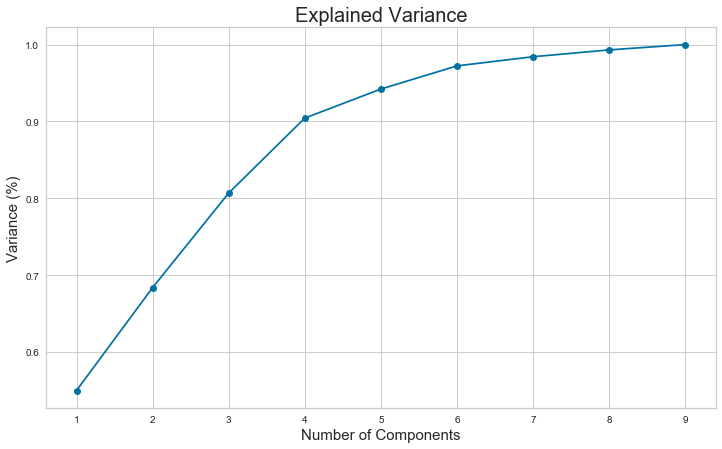

In [127]:
# plot the Cumulative Summation of the Explained Variance
plt.figure(figsize=(12,7))
plt.plot(list('123456789'),np.cumsum(pca.explained_variance_ratio_),marker='o')

# define the labels & title
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15) 
plt.title('Explained Variance', fontsize = 20)

# show the plot
plt.show()

In [128]:
pd.DataFrame({'PCA':list('123456789'),'Variance Explained(%)':np.round(np.cumsum(pca.explained_variance_ratio_)*100,2)})

,PCA,Variance Explained(%)
0,1,55.00
1,2,68.39
2,3,80.69
3,4,90.44
4,5,94.21
5,6,97.23
6,7,98.42
7,8,99.31
8,9,100.00


In [129]:
# we will choose 4 pca components and create a new dataset

country_pca = PCA(n_components=4).fit(data_scaled).transform(data_scaled)

# store it in a new data frame
country_pca= pd.DataFrame(data = country_pca, columns = ['principal component 1', 'principal component 2',
                                                        'principal component 3','principal component 4'])
# country_pca['country'] = country['country']

country_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4
0,-0.599078,0.095490,0.157554,-0.024333
1,0.158474,-0.212092,-0.064189,-0.061247
2,0.003686,-0.135867,-0.134182,0.133574
3,-0.650235,0.275975,-0.142672,0.156018
4,0.200711,-0.064662,-0.100715,-0.037902


In [130]:
#PCA REMOVE MULTICOLLINEARITY
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=[variance_inflation_factor(country_pca.values,i) for i in range(country_pca.shape[1])]
pd.DataFrame({'vif':vif},index=country_pca.columns)

,vif
principal component 1,1.0
principal component 2,1.0
principal component 3,1.0
principal component 4,1.0


In [131]:
#if vif is
#1 = not correlated.
#Between 1 and 5 = moderately correlated.
#Greater than 5 = highly correlated.

## Kmeans Clustering

This is the most popular method of clustering. It uses Euclidean distance between clusters in each iteration to decide a data point should belong to which cluster, and proceed accordingly. To decide how many no. of clusters to consider, we can employ several methods. The basic and most widely used method is Elbow Curve.

#### Method-1: Plotting Elbow Curve

In this curve, wherever we observe a "knee" like bent, we can take that number as the ideal no. of clusters to consider in K-Means algorithm.

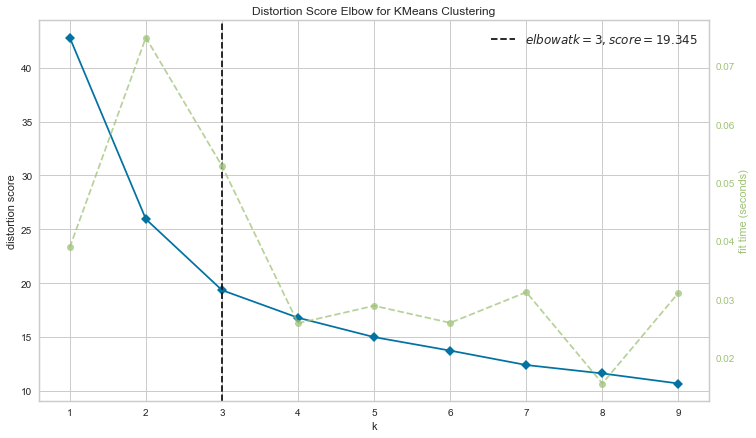

In [132]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

model = KMeans()
plt.figure(figsize=(12,7))
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scaled)    
visualizer.poof()
plt.show()

Here, along Y-axis, "distortion" is defined as "the sum of the squared differences between the observations and the corresponding centroid". It is same as WCSS (Within-Cluster-Sum-of-Squares).

Let's see the centroids of the clusters. Afterwards, we will fit our scaled data into a K-Means model having 3 clusters, and then label each data point (each record) to one of these 3 clusters.



In [133]:
#Fitting data into K-Means model with 3 clusters
km_3=KMeans(n_clusters=3,random_state=0)
km_3.fit(data_scaled)
print(km_3.cluster_centers_)

[[0.0956586  0.20354231 0.27564776 0.27148825 0.09891936 0.1084663
  0.79913396 0.1787592  0.06301822]
 [0.44150332 0.14597042 0.28144675 0.24855348 0.02337632 0.15069832
  0.5383329  0.62148539 0.01398231]
 [0.01088264 0.28914199 0.44196249 0.29131375 0.36819242 0.0628897
  0.95237267 0.09468361 0.41678415]]


In [134]:
print(km_3.labels_)

[1 0 0 1 0 0 0 2 2 0 0 0 0 0 0 2 0 1 0 0 0 0 0 2 0 1 1 0 1 2 0 1 1 0 0 0 1
 1 1 0 1 0 2 2 2 0 0 0 0 1 1 0 0 2 2 1 1 0 2 1 2 0 0 1 1 0 1 0 2 0 0 0 1 2
 2 2 0 2 0 0 1 1 2 0 1 0 0 1 1 0 0 2 0 1 1 0 0 1 2 1 0 0 0 0 0 0 1 0 1 0 2
 2 1 1 2 0 1 0 0 0 0 0 2 2 0 0 1 0 0 1 0 0 1 2 0 2 1 0 2 2 0 0 1 0 2 2 0 1
 0 1 1 0 0 0 0 1 0 2 2 2 0 0 0 0 0 1 1]


In [135]:
pd.Series(km_3.labels_).value_counts()

0    87
1    46
2    34
dtype: int64

We see, the highest no. of records belong to the first cluster.


#### Method-2: Silhouette Coefficients


Now, we are interested to check how good is our K-Means clustering model. Silhouette Coefficient is one such metric to check that. The Silhouette Coefficient is calculated using:

the mean intra-cluster distance ( a ) for each sample

the mean nearest-cluster distance ( b ) for each sample

The Silhouette Coefficient for a sample is (b - a) / max(a, b)

In [136]:
from sklearn import metrics

# calculate SC for K=2 through K=10
k_range = range(2, 10)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(data_scaled)
    scores.append(metrics.silhouette_score(data_scaled, km.labels_))
print(scores)

[0.37671430588173554, 0.34265474105126204, 0.34600192038431477, 0.25486354882852974, 0.2697888376193172, 0.2306629315152745, 0.24309588975314525, 0.20861624436711665]


In [137]:
pd.DataFrame({'clusters':np.arange(2,10),'silhouette_score':scores})

,clusters,silhouette_score
0,2,0.376714
1,3,0.342655
2,4,0.346002
3,5,0.254864
4,6,0.269789
5,7,0.230663
6,8,0.243096
7,9,0.208616


We observe the highest silhouette score with no. of clusters 2, 3 and 4. However, from Elbow Curve, we got to see the "knee" like bent at no. of clusters 3. 

So we will do further analysis to choose the ideal no. of clusters between 2,3 and 4.

#### Method-3: SSE

SSE is the sum of the squared differences between each observation and its cluster's mean. It can be used as a measure of variation within a cluster. If all cases within a cluster are identical the SSE would then be equal to 0.

In [138]:
inertia = []
labels=[]
centroid=[]
# define how many clusters we want to test up to.
num_of_clusters = 10

# run through each instance of K
for k in range(2, num_of_clusters):    
    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k,max_iter=1000,random_state=0).fit(data_scaled)
    inertia.append(kmeans.inertia_)
    labels.append(kmeans.labels_)
    centroid.append(kmeans.cluster_centers_)

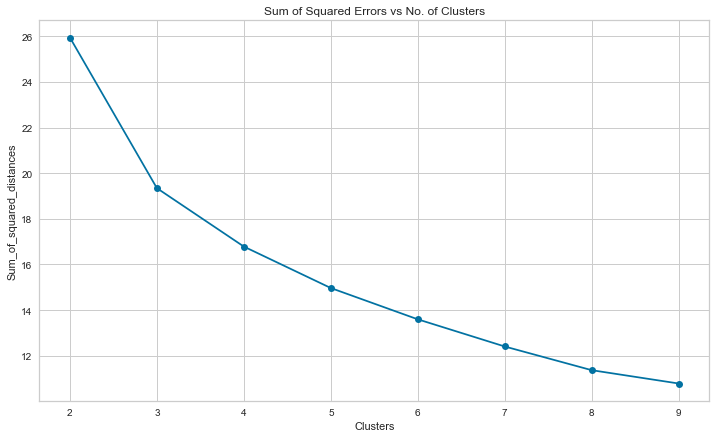

In [139]:
plt.figure(figsize=(12,7))
plt.plot(range(2, num_of_clusters), inertia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Sum of Squared Errors vs No. of Clusters')
plt.show()

In [140]:
#'knee' like bent at cluster 3. So 3 clusters are present.

#### Method-4:  Dendrogram:

In [141]:
#Lets confirm the number of clusters by use of Dendrogram

In [142]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')
model.fit(data_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

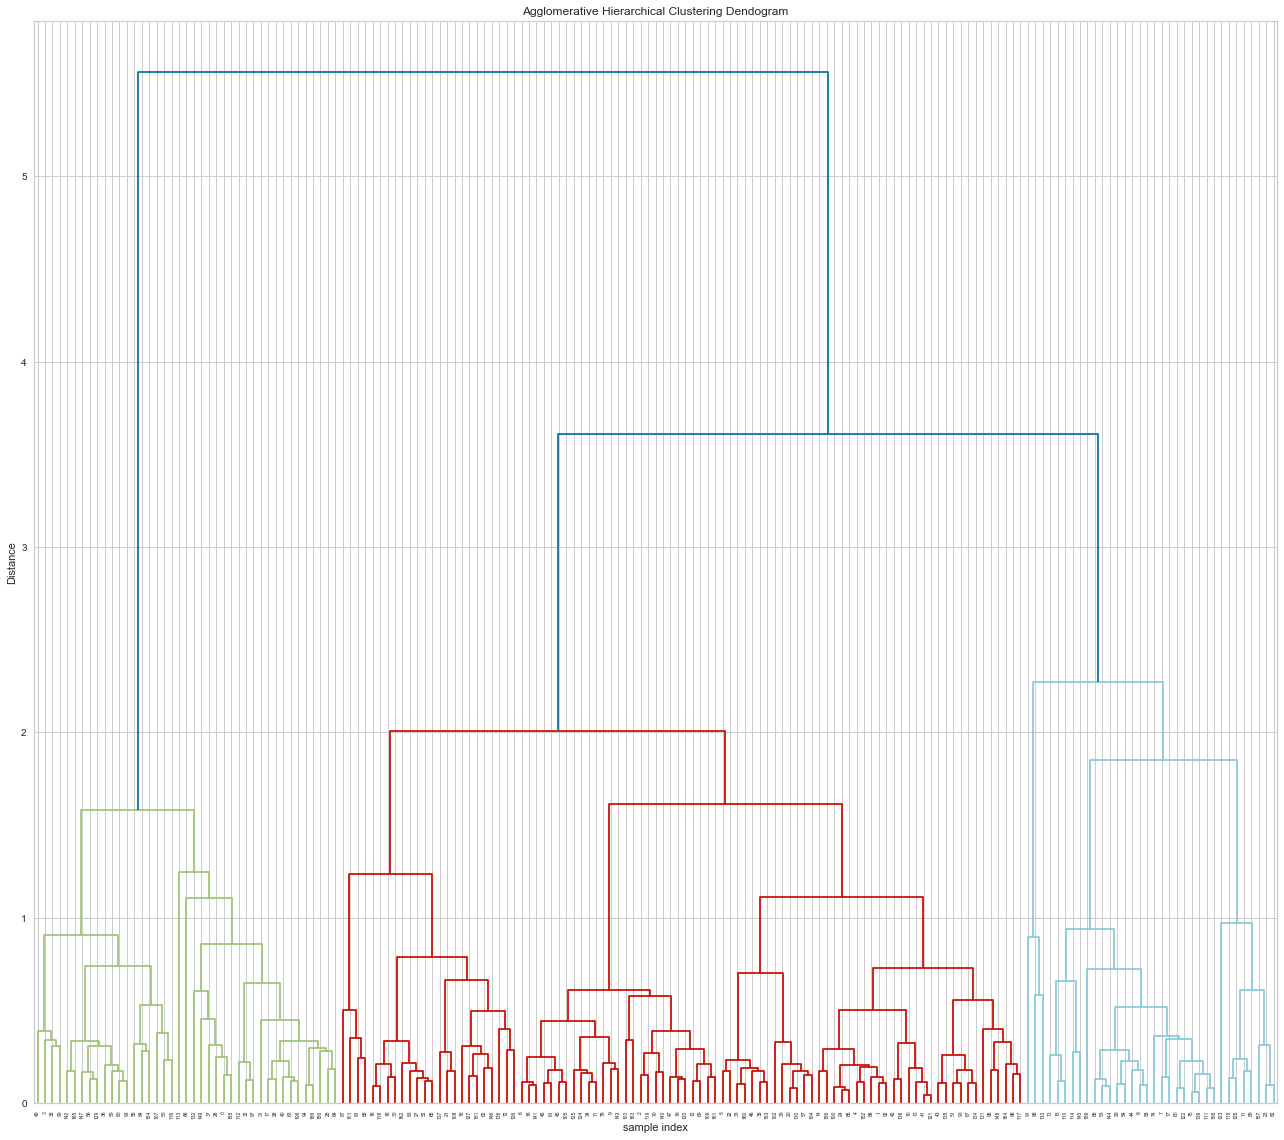

In [143]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
Z = linkage(data_scaled, 'ward')
dendrogram(Z,color_threshold=3)
plt.tight_layout()

## INSIGHTS:

In [144]:
km_3.labels_

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1])

In [145]:
country['cluster']=km_3.labels_
country_pca['cluster']=km_3.labels_

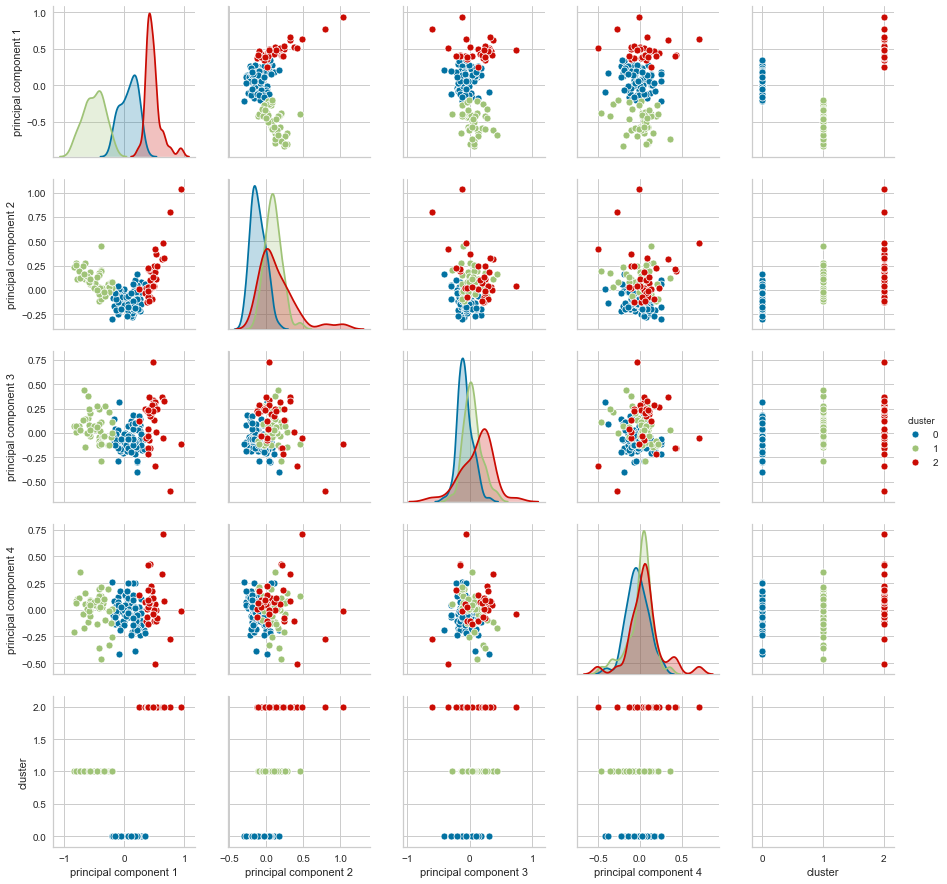

In [146]:
sns.pairplot(country_pca,diag_kind='kde',hue='cluster')
plt.show()

In [147]:
final_df=country
final_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


In [148]:
#calculating mean of the required columns(child_mort, income, gdpp) for comparison

Cluster_GDPP=pd.DataFrame(final_df.groupby(["cluster"]).gdpp.mean())
Cluster_child_mort=pd.DataFrame(final_df.groupby(["cluster"]).child_mort.mean())
Cluster_income=pd.DataFrame(final_df.groupby(["cluster"]).income.mean())
Cluster_count=pd.DataFrame({'num_of_countries':final_df.groupby(["cluster"])['cluster'].count()})
data = pd.concat([Cluster_GDPP,Cluster_child_mort,Cluster_income,Cluster_count], axis=1)
data

,gdpp,child_mort,income,num_of_countries
cluster,,,,
0,6833.356322,22.248276,12913.678161,87
1,1695.913043,93.284783,3516.804348,46
2,43897.058824,4.835294,46408.823529,34


In [149]:
#Cluster2===> countries with highest gdp per capita,highest income and lowest mortality(Developed Countries)
#cluster1===> countries with lowest gdp per capita,lowest income and highest mortality(UnderDeveloped Countries)
#Cluster0===> countries with mid gdp per capita,mid income and mid mortality(Developing Countries)

In [150]:
data.rename(index={0: 'Developing'},inplace=True)
data.rename(index={1: 'Under-developed'},inplace=True)
data.rename(index={2: 'Developed'},inplace=True)
data

,gdpp,child_mort,income,num_of_countries
cluster,,,,
Developing,6833.356322,22.248276,12913.678161,87
Under-developed,1695.913043,93.284783,3516.804348,46
Developed,43897.058824,4.835294,46408.823529,34


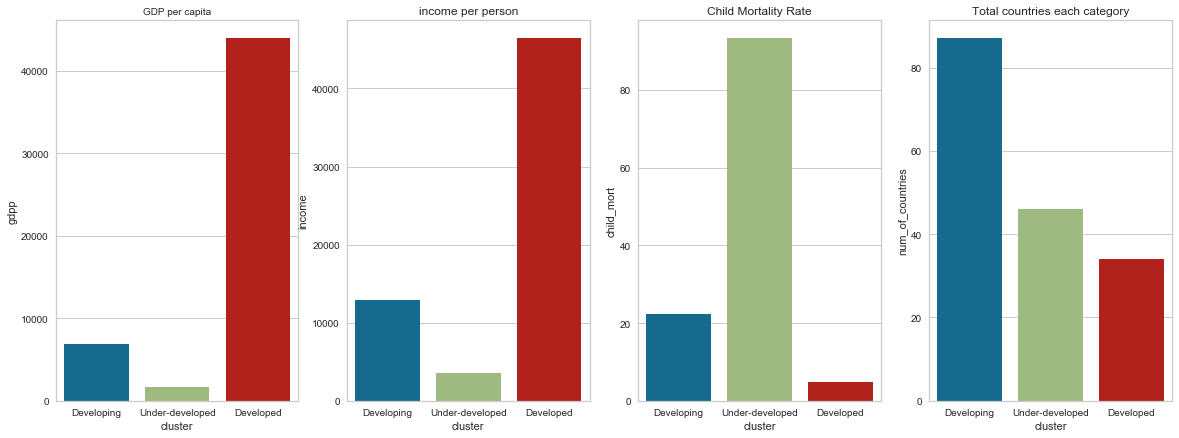

In [151]:
f, axes = plt.subplots(1, 4, figsize=(20,7))

sns.barplot(x=data.index,y='gdpp',data=data,ax=axes[0])
axes[0].set_title('GDP per capita',fontsize=10)

sns.barplot(x=data.index,y='income',data=data,ax=axes[1])
axes[1].set_title('income per person')

sns.barplot(x=data.index,y='child_mort',data=data,ax=axes[2])
axes[2].set_title('Child Mortality Rate')

sns.barplot(x=data.index,y='num_of_countries',data=data,ax=axes[3])
axes[3].set_title('Total countries each category')

plt.show()

Above bar chart shows that,

- All the developed countries are having high GDP per capita values, developing countries are having average GDP per capita values and poor countries are having the least GDPP values.
- All the developed countries are having high income per person, developing countries are having average income per person and poor countries are having the least income per person.
- All the developed countries are having low number of death of children under 5 years of age per 1000 live births, developing countries are having average death rate and poor countries are having the least death rate.
- There are more developing countries than under-developed and developed countries combined.

In [152]:
country['cluster']=country['cluster'].apply(lambda x: 'Developing' if x==0 else('Under-developed' if x==1 else 'Developed'))

In [153]:
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,Under-developed
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,Developing
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,Developing
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,Under-developed
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,Developing


## Developed countries:

#### Let's find out top 10 developed countries with highest gdpp

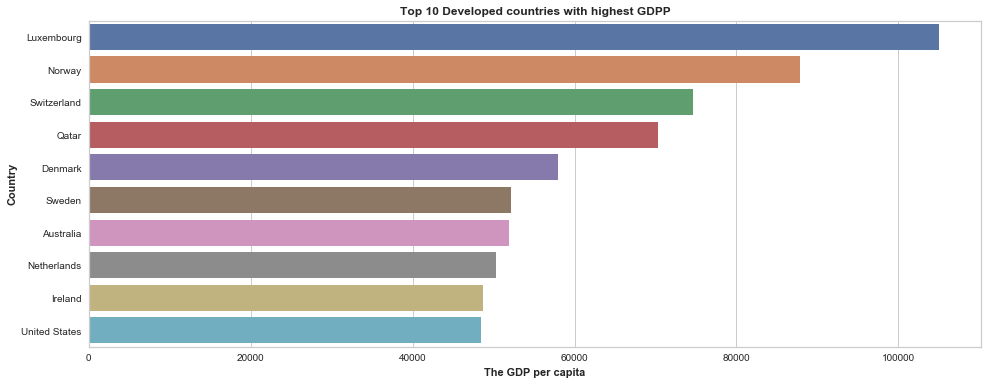

In [154]:
dev_gdpp = country[country.cluster=='Developed'].sort_values(by='gdpp',ascending=False)

plt.figure(figsize=(16,6))
ax = sns.barplot(x=dev_gdpp['gdpp'].head(10), y=dev_gdpp['country'].head(10), data=dev_gdpp, palette='deep')

plt.title('Top 10 Developed countries with highest GDPP', weight='bold')
plt.xlabel('The GDP per capita', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

#### Let's find out top 10 developed countries with lowest gdpp

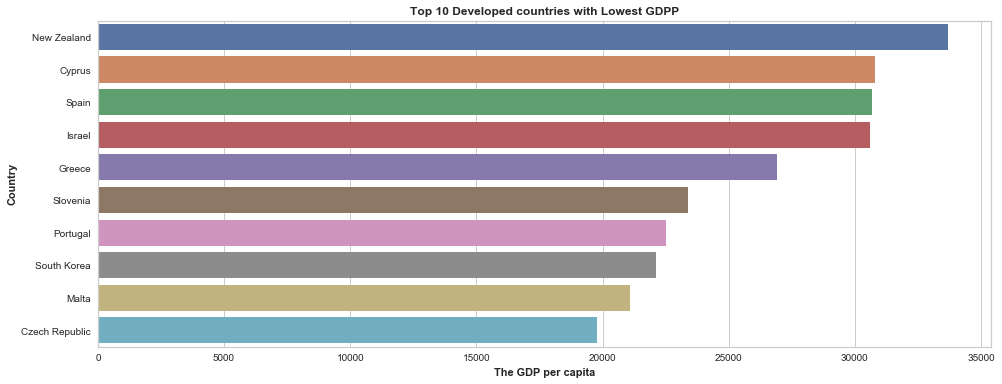

In [155]:
dev_gdpp = country[country.cluster=='Developed'].sort_values(by='gdpp',ascending=False)

plt.figure(figsize=(16,6))
ax = sns.barplot(x=dev_gdpp['gdpp'].tail(10), y=dev_gdpp['country'].tail(10), data=dev_gdpp, palette='deep')

plt.title('Top 10 Developed countries with Lowest GDPP', weight='bold')
plt.xlabel('The GDP per capita', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

#### Let's find out top 10 developed countries with highest income

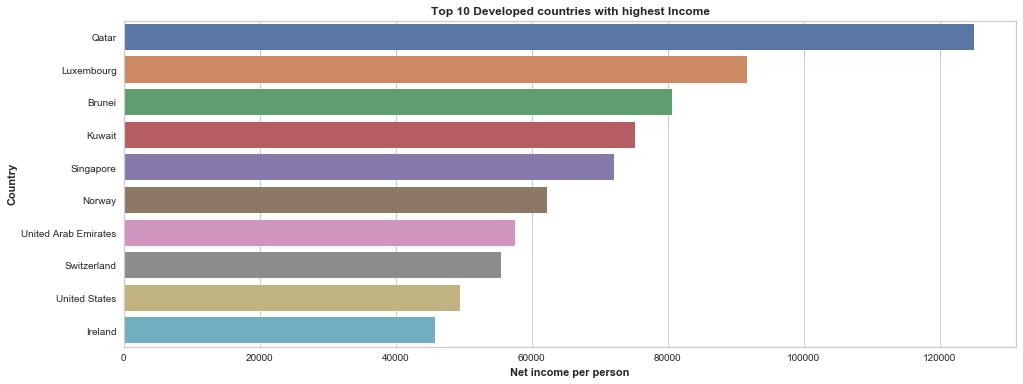

In [156]:
dev_inc = country[country.cluster=='Developed'].sort_values(by='income',ascending=False)

plt.figure(figsize=(16,6))
ax = sns.barplot(x=dev_inc['income'].head(10), y=dev_inc['country'].head(10), data=dev_inc, palette='deep')

plt.title('Top 10 Developed countries with highest Income', weight='bold')
plt.xlabel('Net income per person', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

#### Let's find out top 10 developed countries with lowest income

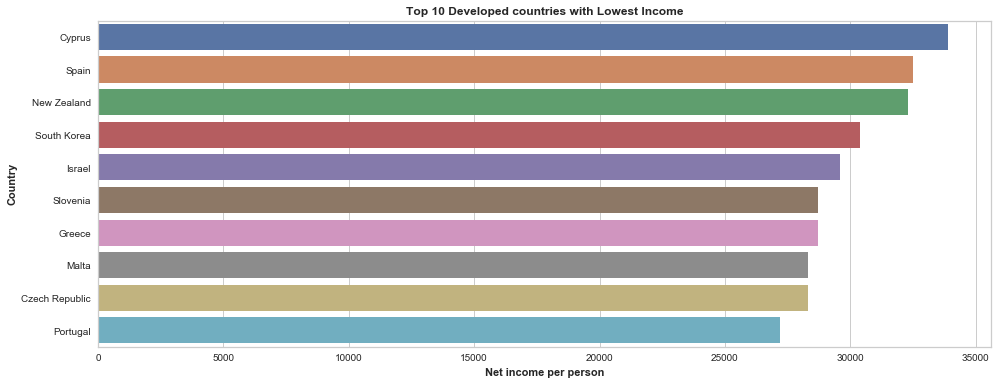

In [157]:
dev_inc = country[country.cluster=='Developed'].sort_values(by='income',ascending=False)

plt.figure(figsize=(16,6))
ax = sns.barplot(x=dev_inc['income'].tail(10), y=dev_inc['country'].tail(10), data=dev_inc, palette='deep')

plt.title('Top 10 Developed countries with Lowest Income', weight='bold')
plt.xlabel('Net income per person', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

#### Let's find out top 10 developed countries with highest exports

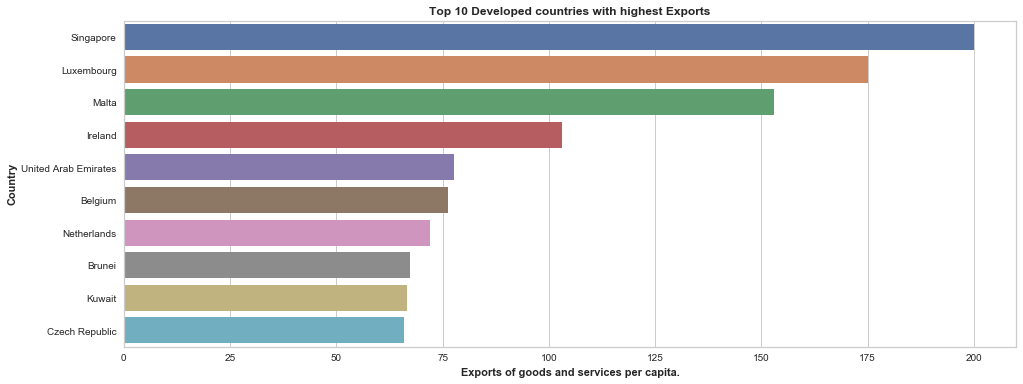

In [158]:
dev_exp = country[country.cluster=='Developed'].sort_values(by='exports',ascending=False)

plt.figure(figsize=(16,6))
ax = sns.barplot(x=dev_exp['exports'].head(10), y=dev_exp['country'].head(10), data=dev_exp, palette='deep')

plt.title('Top 10 Developed countries with highest Exports', weight='bold')
plt.xlabel('Exports of goods and services per capita.', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

#### Let's find out top 10 developed countries with highest imports

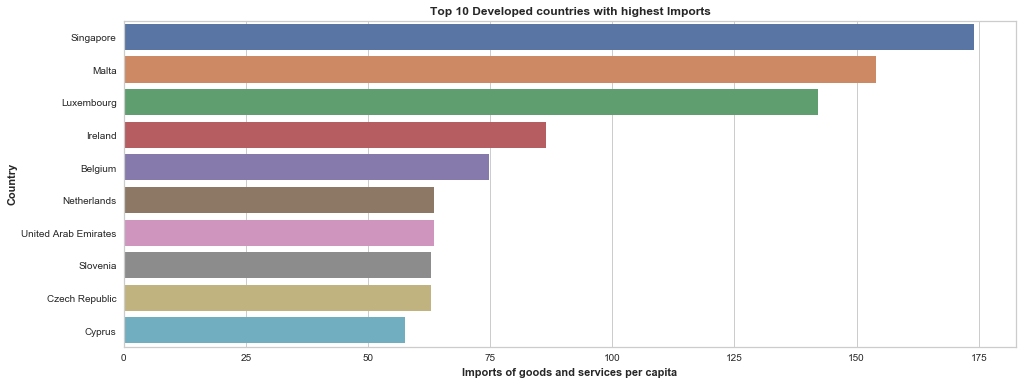

In [159]:
dev_imp = country[country.cluster=='Developed'].sort_values(by='imports',ascending=False)

plt.figure(figsize=(16,6))
ax = sns.barplot(x=dev_imp['imports'].head(10), y=dev_imp['country'].head(10), data=dev_imp, palette='deep')

plt.title('Top 10 Developed countries with highest Imports', weight='bold')
plt.xlabel('Imports of goods and services per capita', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

## Top 10 Countries in dire needs:

In [181]:
data

,gdpp,child_mort,income,num_of_countries
cluster,,,,
Developing,6833.356322,22.248276,12913.678161,87
Under-developed,1695.913043,93.284783,3516.804348,46
Developed,43897.058824,4.835294,46408.823529,34


We'll select countries who's 

gdpp is less than 1695(mean gdpp),  

child mortality is > 93(mean child_mort) and

income <=3516 and select top 10 countries

In [182]:
needy=country[country['gdpp']<=1695]
needy=needy[needy['child_mort']>= 93]
needy=needy[needy['income']<= 3516]
needy.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,Under-developed
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,Under-developed
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,Under-developed
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,Under-developed
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,Under-developed


In [183]:
needy=needy.sort_values(by=['gdpp','income','child_mort'],ascending=[True,True,False])
needy.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,Under-developed
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,Under-developed
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,Under-developed
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,Under-developed
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,Under-developed
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,Under-developed
64,Guinea-Bissau,114.0,14.90,8.50,35.2,1390,2.97,55.6,5.05,547,Under-developed
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.81,57.9,5.87,575,Under-developed
63,Guinea,109.0,30.30,4.93,43.2,1190,16.10,58.0,5.34,648,Under-developed
66,Haiti,208.0,15.30,6.91,64.7,1500,5.45,32.1,3.33,662,Under-developed


In [194]:
print ("\033[4mCOUNTRIES IN DIRE NEEDS: \033[0m\n")

for i in needy.country[:10]:
    print(i)

COUNTRIES IN DIRE NEEDS: 

Burundi
Congo, Dem. Rep.
Niger
Sierra Leone
Mozambique
Central African Republic
Guinea-Bissau
Burkina Faso
Guinea
Haiti
